# Data Exploration: Tourism in Finland

As an avid traveller myself, I am always interested in Finland from a tourism point of view - what is Finland like as a destination? How popular is it? How is it perceived?

Anecdotally, I have felt that Finland has become an increasingly attractive travel destination, as I seem to see more and more tourists when walking around the streets of Helsinki.
Further, based on media articles it has seemed to me that Finnish Lapland has been an attractive destination especially to Asians due to the winter experience, polar lights, and Santa Claus. 

I am interested to see if these ideas are also supported by the data as well. 
The data is openly available and supplied by Visit Finland.
It was gathered manually from their table [web interface](https://visitfinland.stat.fi/PXWeb/pxweb/fi/VisitFinland/VisitFinland__Majoitustilastot/visitfinland_matk_pxt_116n.px/). 

### Setup

The data used in the notebook is manually fetched due to this being a quick-and-dirty data exploration, and not a production-type implementation.
Hence it requires some manual setting up.


To run this notebook, you should choose the following columns from the online database:

- Tiedot:
   - Saapuneet
   - Saapuneet muutos, lkm
   - Saapuneet muutos, %
- Alue:
   - KOKO MAA
   - SA PÄÄKAUPUNKISEUTU
   - SA LAPPI JA KUUSAMO
- Asuinmaa: All fields
- Kuukausi: All fields.

The data should be saved locally to a path `data/visitor_data_raw.csv` (or if not, remember to format the path code to fetch the correct code).

You should also fetch the country name translation mappings into a .csv file manually.
This can be easily done with Google.



To start coding, we first load packages and raw data:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

%matplotlib inline

# Suppress all warnings
warnings.filterwarnings("ignore")

# Use seaborn themes for plotting
sns.set_theme()

In [2]:
data = pd.read_csv("data/visitor_data_raw.csv", sep=";")
data.head()

,Kuukausi,Saapuneet KOKO MAA Ulkomaiset,Saapuneet KOKO MAA EU-28,Saapuneet KOKO MAA Skandinavia,Saapuneet KOKO MAA Aasia,Saapuneet KOKO MAA Oseania,Saapuneet KOKO MAA Afrikka,Saapuneet KOKO MAA Amerikka,Saapuneet KOKO MAA Venäjä,Saapuneet KOKO MAA Saksa,...,"Saapuneiden muutos, % SA LAPPI JA KUUSAMO Tsekki","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Turkki","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Ukraina","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Unkari","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Uruguay","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Uusi-Seelanti","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Valko-Venäjä","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Venezuela","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Vietnam","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Muut maat"
0,1995M01,75195,41311,17791,4171,272,172,3825,18082,6411,...,.,.,.,.,.,.,.,.,.,.
1,1995M02,72455,41489,18117,4444,208,148,4265,13939,8643,...,.,.,.,.,.,.,.,.,.,.
2,1995M03,93451,53894,25329,4631,350,201,5706,18079,8922,...,.,.,.,.,.,.,.,.,.,.
3,1995M04,76014,44103,21009,4154,351,265,5127,13472,5733,...,.,.,.,.,.,.,.,.,.,.
4,1995M05,115716,71598,35488,7968,880,404,8916,13707,14107,...,.,.,.,.,.,.,.,.,.,.


The table contains month-partitioned data between 1995-2023. 
The columns seem to be in Finnish, where visitor counts are given on different area levels: there are larger areas/continents as well was countries.
Visitor counts can also be found for some specific Finnish regions such as Helsinki Metropolitan area and Lapland.



### Processing

There are several processing steps we need to do get the data ready for exploration, the first being converting the date to a `datetime` object.
This makes vizualizing and handling time series data a lot easier.

In [3]:
data["year_month"] = data["Kuukausi"].str.replace("*", "", regex=False)
data["year_month"] = pd.to_datetime(data["year_month"], format="%YM%m")
data = data.set_index("year_month")
data = data.drop(columns=["Kuukausi"])  # Not needed anymore
data.head()

,Saapuneet KOKO MAA Ulkomaiset,Saapuneet KOKO MAA EU-28,Saapuneet KOKO MAA Skandinavia,Saapuneet KOKO MAA Aasia,Saapuneet KOKO MAA Oseania,Saapuneet KOKO MAA Afrikka,Saapuneet KOKO MAA Amerikka,Saapuneet KOKO MAA Venäjä,Saapuneet KOKO MAA Saksa,Saapuneet KOKO MAA Ruotsi,...,"Saapuneiden muutos, % SA LAPPI JA KUUSAMO Tsekki","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Turkki","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Ukraina","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Unkari","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Uruguay","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Uusi-Seelanti","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Valko-Venäjä","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Venezuela","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Vietnam","Saapuneiden muutos, % SA LAPPI JA KUUSAMO Muut maat"
year_month,,,,,,,,,,,,,,,,,,,,,
1995-01-01,75195,41311,17791,4171,272,172,3825,18082,6411,12080,...,.,.,.,.,.,.,.,.,.,.
1995-02-01,72455,41489,18117,4444,208,148,4265,13939,8643,12042,...,.,.,.,.,.,.,.,.,.,.
1995-03-01,93451,53894,25329,4631,350,201,5706,18079,8922,16928,...,.,.,.,.,.,.,.,.,.,.
1995-04-01,76014,44103,21009,4154,351,265,5127,13472,5733,14876,...,.,.,.,.,.,.,.,.,.,.
1995-05-01,115716,71598,35488,7968,880,404,8916,13707,14107,26511,...,.,.,.,.,.,.,.,.,.,.


The first dataset that we will extract is the visitor data on the entire Finland level. This is found in all columns containing `"Saapuneet KOKO MAA"` in the column name.

In [4]:
cols = data.columns
cols_whole_finland = cols[cols.str.contains("Saapuneet KOKO MAA")]
data_whole_country = data[cols_whole_finland]
data_whole_country.head()

,Saapuneet KOKO MAA Ulkomaiset,Saapuneet KOKO MAA EU-28,Saapuneet KOKO MAA Skandinavia,Saapuneet KOKO MAA Aasia,Saapuneet KOKO MAA Oseania,Saapuneet KOKO MAA Afrikka,Saapuneet KOKO MAA Amerikka,Saapuneet KOKO MAA Venäjä,Saapuneet KOKO MAA Saksa,Saapuneet KOKO MAA Ruotsi,...,Saapuneet KOKO MAA Tsekki,Saapuneet KOKO MAA Turkki,Saapuneet KOKO MAA Ukraina,Saapuneet KOKO MAA Unkari,Saapuneet KOKO MAA Uruguay,Saapuneet KOKO MAA Uusi-Seelanti,Saapuneet KOKO MAA Valko-Venäjä,Saapuneet KOKO MAA Venezuela,Saapuneet KOKO MAA Vietnam,Saapuneet KOKO MAA Muut maat
year_month,,,,,,,,,,,,,,,,,,,,,
1995-01-01,75195,41311,17791,4171,272,172,3825,18082,6411,12080,...,243,83,56,278,1,25,32,54,11,232
1995-02-01,72455,41489,18117,4444,208,148,4265,13939,8643,12042,...,211,121,243,313,0,27,82,26,2,222
1995-03-01,93451,53894,25329,4631,350,201,5706,18079,8922,16928,...,213,154,70,349,2,25,20,44,7,232
1995-04-01,76014,44103,21009,4154,351,265,5127,13472,5733,14876,...,310,129,56,238,5,24,19,19,13,237
1995-05-01,115716,71598,35488,7968,880,404,8916,13707,14107,26511,...,487,254,46,417,11,122,39,49,30,425


The column names are still a bit messy. We can clean them up by strippping the `"Saapuneet KOKO MAA"`-flag from the name, and renaming some columns to be more succinct.

In [5]:
data_whole_country.columns = data_whole_country.columns.str.replace("Saapuneet KOKO MAA ", "")
rename_dict = {
    "Ulkomaiset": "total",
    "Yhdysvallat (USA)": "USA",
    "Korean demokraattinen kansantasavalta (Pohjois-Korea)": "Pohjois-Korea",
    "Korean tasavalta (Etelä-Korea)": "Etelä-Korea",
}
data_whole_country = data_whole_country.rename(columns=rename_dict)
data_whole_country.head()

,total,EU-28,Skandinavia,Aasia,Oseania,Afrikka,Amerikka,Venäjä,Saksa,Ruotsi,...,Tsekki,Turkki,Ukraina,Unkari,Uruguay,Uusi-Seelanti,Valko-Venäjä,Venezuela,Vietnam,Muut maat
year_month,,,,,,,,,,,,,,,,,,,,,
1995-01-01,75195,41311,17791,4171,272,172,3825,18082,6411,12080,...,243,83,56,278,1,25,32,54,11,232
1995-02-01,72455,41489,18117,4444,208,148,4265,13939,8643,12042,...,211,121,243,313,0,27,82,26,2,222
1995-03-01,93451,53894,25329,4631,350,201,5706,18079,8922,16928,...,213,154,70,349,2,25,20,44,7,232
1995-04-01,76014,44103,21009,4154,351,265,5127,13472,5733,14876,...,310,129,56,238,5,24,19,19,13,237
1995-05-01,115716,71598,35488,7968,880,404,8916,13707,14107,26511,...,487,254,46,417,11,122,39,49,30,425


And we can translate region names with the `countries_translations`-mapping

In [6]:
translations = pd.read_csv("data/countries_translations.csv")
data_whole_country = data_whole_country.rename(
    columns=dict(zip(translations["area_fin"], translations["area_eng"]))
)
data_whole_country.head()

,total,EU-28,Skandinavia,Asia,Oceania,Africa,Americas,Russia,Germany,Sweden,...,Tsekki,Turkey,Ukraine,Hungary,Uruguay,New Zealand,Belarus,Venezuela,Vietnam,Muut maat
year_month,,,,,,,,,,,,,,,,,,,,,
1995-01-01,75195,41311,17791,4171,272,172,3825,18082,6411,12080,...,243,83,56,278,1,25,32,54,11,232
1995-02-01,72455,41489,18117,4444,208,148,4265,13939,8643,12042,...,211,121,243,313,0,27,82,26,2,222
1995-03-01,93451,53894,25329,4631,350,201,5706,18079,8922,16928,...,213,154,70,349,2,25,20,44,7,232
1995-04-01,76014,44103,21009,4154,351,265,5127,13472,5733,14876,...,310,129,56,238,5,24,19,19,13,237
1995-05-01,115716,71598,35488,7968,880,404,8916,13707,14107,26511,...,487,254,46,417,11,122,39,49,30,425


Looks a lot better.

---

### Visualizations

Lets first simply plot the raw time series data:


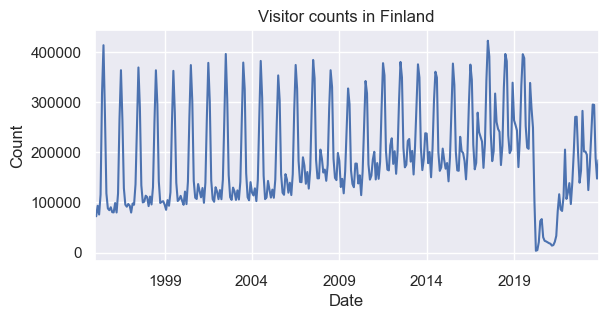

In [7]:
ts = pd.DataFrame(data_whole_country["total"])
ts.plot(
    legend=False,
    title="Visitor counts in Finland",
    xlabel="Date",
    ylabel="Count",
    figsize=(6.5, 3),
)
plt.show()

As expected, there is a *heavy* seasonal aspect in the data.
This is most likely a summer peak, where people travel during the holiday season.
We can check this with decomposed time series plots:

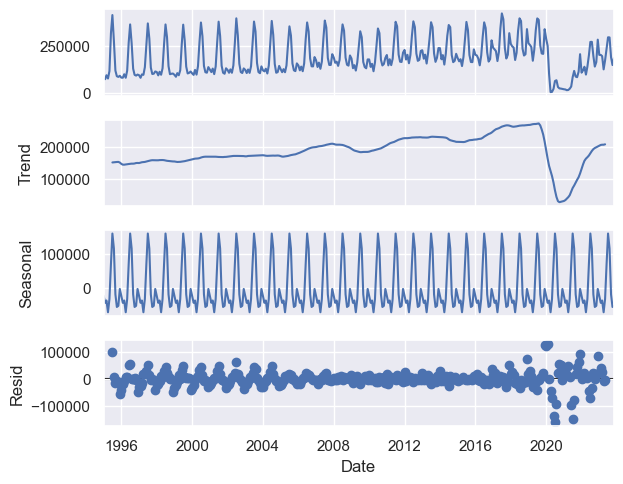

In [8]:
seasonal_decompose(ts).plot()
plt.xlabel("Date")
plt.show()

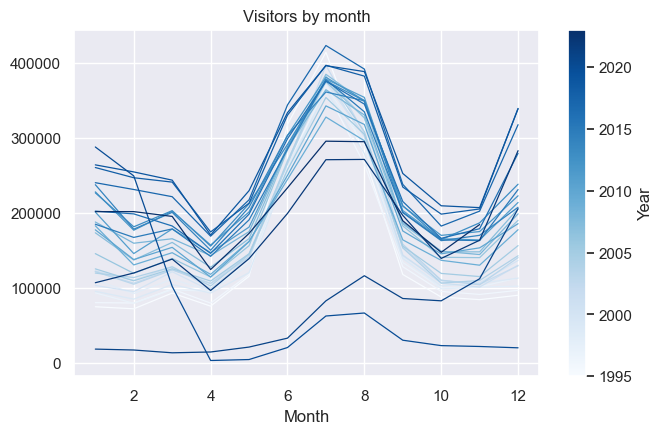

In [9]:
# Extract year and month information
ts.loc[:, "year"] = ts.index.year
ts.loc[:, "month"] = ts.index.month
ts

# Pivot the DataFrame to have each year as its own column
pivot_df = ts.pivot_table(index="month", columns="year", values="total", aggfunc="first")

# Plot data
fig, ax = plt.subplots()
cmap = cm.get_cmap("Blues")
pivot_df.plot(
    legend=False,
    colormap=cmap,
    linewidth=0.9,
    ax=ax,
    figsize=(7.5, 4.5),
    title="Visitors by month",
    xlabel="Month",
)

# Create a ScalarMappable for the color gradient bar
start_year = pivot_df.columns[0]
end_year = pivot_df.columns[-1]
norm = Normalize(vmin=start_year, vmax=end_year)
sm = ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])

# Add a colorbar with the ScalarMappable
cbar = plt.colorbar(sm, ax=ax, label="Year")

There is clearly a seasonal peak around the summer months. Also, as expected months around christmas are also quite busy, probably with Lapland attracting a many visitors. 
The two outlying lines are most likely the covid years, where the entire world stopped an focused on surviving the pandemic.
During this time, minimal visitors came

Overall, from these images it can be seen that there is a gradual positive trend in visitor counts, up until 2020.
After that, they have recovered, but not to the level that they were before COVID. 
In fact, the first time series show that the peaks during the last two years are still the lowest recorded. 
From that point of view, although it can be historically said that more and more people come visit Finland, it can not be said that currently in 2023 there are more tourists visiting Finland than ever.

Even so, visit numbers have increased significantly after COVID, and since before the pandemic, there was constant growth in visitor counts, we can expect Finnish tourist numbers to keep increasing, and possibly exceeding the previous peak somewhere in the near future.

--- 

### Demographics

Lets first plot visitor counts by region to see if indeed Asian tourists are over-represented

In [10]:
data_2023 = pd.DataFrame(
    data_whole_country[data_whole_country.index.year == 2023].sum(), columns=["visitors"]
)

regions = ["EU-28", "Asia", "Oceania", "Africa", "Americas"]
region_data = data_2023.loc[regions].sort_values("visitors", ascending=False)

drop = ["total", "Skandinavia", *regions, "Muut maat"]
top10_countries = data_2023.drop(drop).sort_values("visitors", ascending=False)[:10]

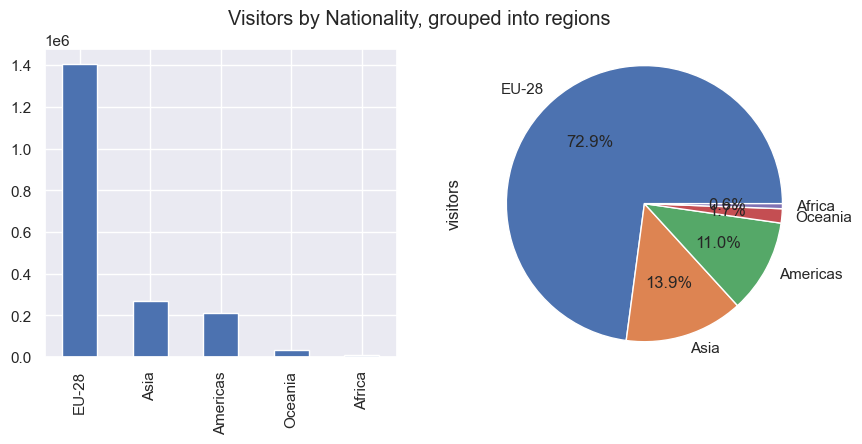

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))


region_data.plot(kind="bar", ax=axs[0], legend=None)
region_data.plot(kind="pie", y="visitors", ax=axs[1], legend=False, autopct="%1.1f%%")
plt.suptitle("Visitors by Nationality, grouped into regions")
plt.axis("equal")
plt.show()

We can see that EU-28 nationalities are by far the most popular nationality "group" of the people arriving in Finland.
This is expected, as those countries have the shortest distance to travel.
Asia is the next most popular nationality region.
However, its actually difficult to determine if a region is over-represented or not - how define such thing? 
By percentage of population? By distance of travel to Finland? By economic situation? Buying power? Average amount of holidays?

For example, EU-28 population is approx 448 million while 4.5 **billion**, so from that point of view, there are proportionately less visitors than when compared with EU countries.
However, when factoring in average duration and price of travel, the interpretation differs.

The way one interprets these results depends on one's contextual understanding and cultural bias as well as how they value different "representation" factors.
Overall, however, one can objectively say that of the people visiting Finland, an overwhelming majority has an EU-28 nationality.

#### Visitors by nationality


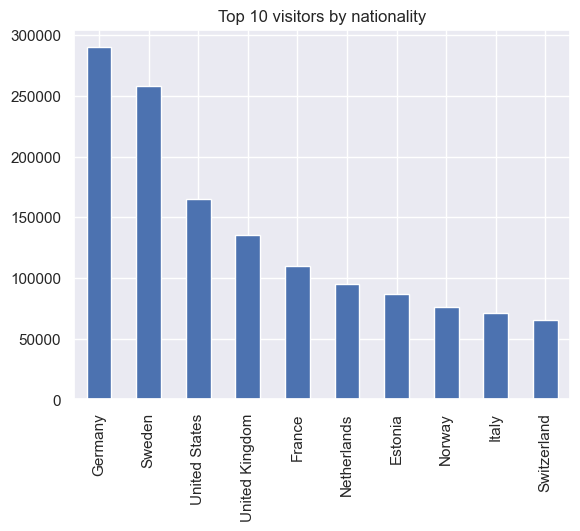

In [12]:
top10_countries.plot(kind="bar", legend=None, title="Top 10 visitors by nationality")
plt.show()

Germany seems to be the top country for Finnish visits, with Sweden being a close second. 
This is somewhat expected, as Sweden is a neighbor of Finland, and Germany is a leading European country by economy, allowing for residents for travel abroad. 

Somewhat interstingly, the United States is third, even though the Americas were only the thrid most populous region.
This suggests that Southern America and Central America probably did not have a lot of visitors.
We could test this out by plotting the visitor counts of some American countries that come to mind:


<AxesSubplot:title={'center':'Some visitor counts, American nationality'}>

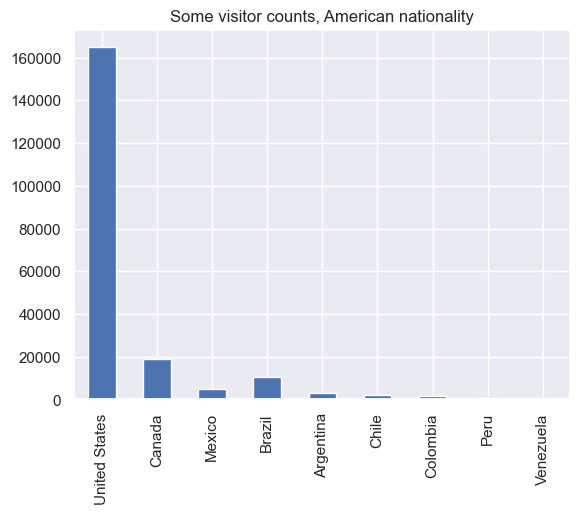

In [13]:
countries_list = [
    "United States",
    "Canada",
    "Mexico",
    "Brazil",
    "Argentina",
    "Chile",
    "Colombia",
    "Peru",
    "Venezuela",
]
data_2023.loc[countries_list].plot(
    kind="bar", legend=None, title="Some visitor counts, American nationality"
)

Visitor counts are definitely dominated by the US.

All of the other countries are European, supporting the "EU overwhelming majority narrative", with Finnish neighboring countries being also represented in the list (as expected).
However, none of the Asian countries are shown. To look closer how visitor counts were distributed, lets make a similar bar chart:

<AxesSubplot:title={'center':'Some visitor counts, Asian nationality. US for scale'}>

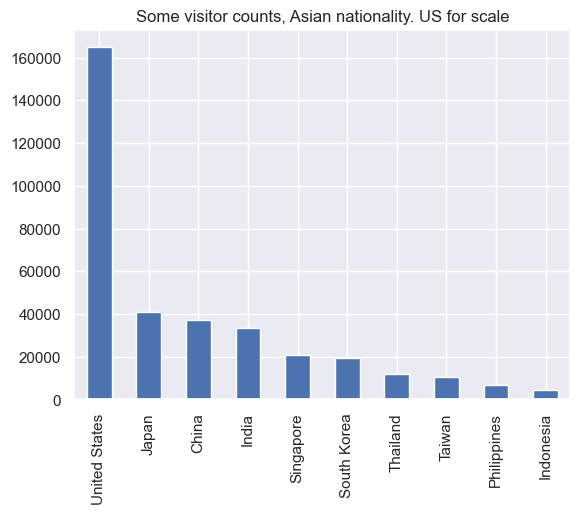

In [14]:
countries_list = [
    "United States",
    "China",
    "India",
    "Indonesia",
    "South Korea",
    "Thailand",
    "Japan",
    "Philippines",
    "Singapore",
    "Taiwan",
]
data_2023.loc[countries_list].sort_values(by="visitors", ascending=False).plot(
    kind="bar", legend=None, title="Some visitor counts, Asian nationality. US for scale"
)

We can see that although the US visitor count larger by a factor, Asia contains many countries with a lot more visitors than the American equivalents. 
Hence this builds up to form a larger visitor total.
For asian countries, there is a relatively even top 3, with Japan having the most visitors.
This is impressive considering the vast size difference between Japan and China or India.

---


## Conlcuding remarks

Throughout this exploration we have looked into tourist data of visitors coming to Finland.
We have used time series plots, pie charts, and bar charts to evaluate visitor trends, and demographic proportions of certain visitor groups. 
Are findings are approximately the following.
- Visitor counts were growing somewhat monotonicly until COVID.
- Visitor counts are highly seasonal with a peak during the summer and a secondary peak around christmas.
- After COVID, visitor counts have rebounded but are still not as high as they were.
- EU-28 is the largest nationality group (72,9%), with Asia being the second.
- Germany, Sweden, and the US are the top 30 visiting countries.


Finally, lets save the data for us to use later:

In [16]:
data_whole_country.to_csv("data/visitor_data.csv")